# Integrating NZRA and Satellite data

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from convcnp_assim_nz.data_processing.nzra_processor import ProcessNZRA
from convcnp_assim_nz.utils.variables.var_names import *
from convcnp_assim_nz.utils.variables.coord_names import *
from convcnp_assim_nz.data_processing.conversions.scalar_conversions import kelvin_to_celsius
from convcnp_assim_nz.config.env_loader import use_absolute_filepaths

In [3]:
# set to use absolute filepaths
# this is needed when data isn't stored relative to DATA_HOME
# you would likely not set this to true if using a university or personal computer with data stored tidily in a data directory
use_absolute_filepaths(mode=True)

### Use the new data loader for NZRA

In [4]:
nzra_processor = ProcessNZRA()

In [5]:
ds = nzra_processor.load_ds([2017])

ds[TEMPERATURE] = kelvin_to_celsius(ds[TEMPERATURE])

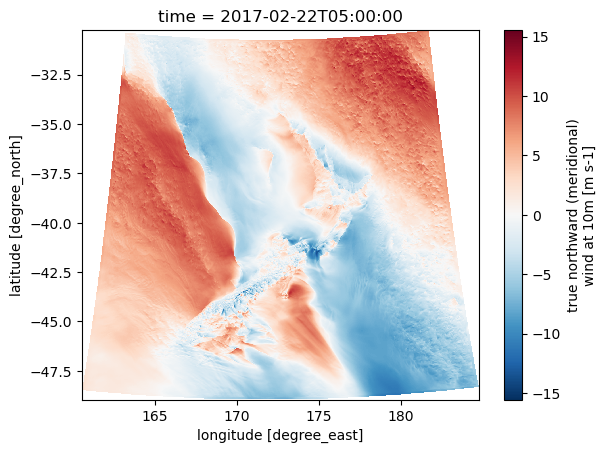

In [11]:
ds.isel(time=2500)[WIND_U].plot()

In [12]:
import matplotlib.pyplot as plt
import numpy as np

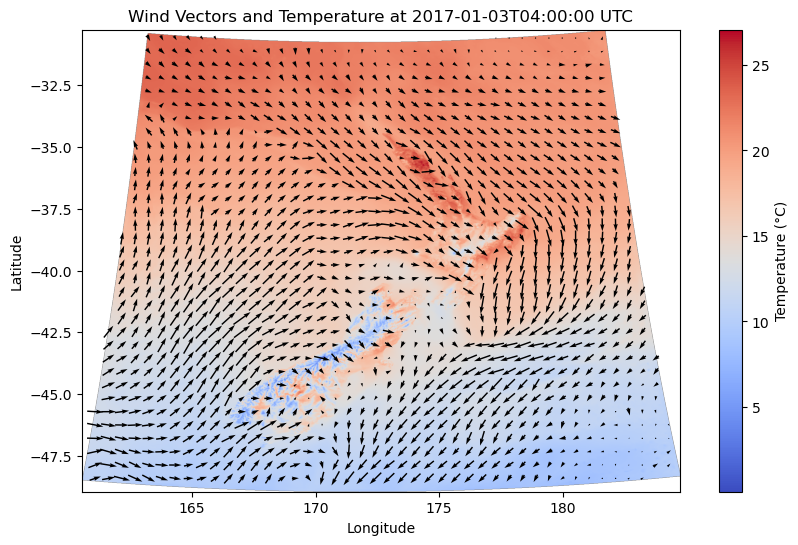

In [20]:
t = "2017-01-03T04:00:00"
step = 40

u = ds.sel(time=t)[WIND_U].isel(lat=slice(None, None, step), lon=slice(None, None, step))
v = ds.sel(time=t)[WIND_V].isel(lat=slice(None, None, step), lon=slice(None, None, step))

lons = u["lon"].values
lats = u["lat"].values
Lon, Lat = np.meshgrid(lons, lats)

plt.figure(figsize=(10, 6))

temp = ds.sel(time=t)[TEMPERATURE].values
lon_min, lon_max = float(ds["lon"].values.min()), float(ds["lon"].values.max())
lat_min, lat_max = float(ds["lat"].values.min()), float(ds["lat"].values.max())
#plt.imshow(temp, extent=[lon_min, lon_max, lat_min, lat_max], origin="lower", cmap="coolwarm", aspect="auto")
im = plt.imshow(temp, extent=[lon_min, lon_max, lat_min, lat_max], origin="lower", cmap="coolwarm")

plt.quiver(Lon, Lat, v.values, u.values, pivot="middle", scale=400)

plt.title(f"Wind Vectors and Temperature at {t} UTC")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(im, label="Temperature (°C)") # this doesn't show the correct range?
plt.show()

The NZRA data looks good!

### Load the Satellite data from the Himawari 8 loader

In [4]:
%autoreload 2
from convcnp_assim_nz.data_processing.himawari8_processor import ProcessHimawari8

In [5]:
himawari8_processor = ProcessHimawari8()

In [14]:
import glob
import xarray as xr
from datetime import datetime
from dask.diagnostics import ProgressBar

pattern = (
    "/esi/project/niwa00004/meyerstj/data/ml-datasets/himawari8/"
    "regridded/2017*/AHI_L1B_2017*10_NZCSM.nc"
)

h8_files = glob.glob(pattern)

def preprocess(ds: xr.Dataset, latitude=ds[LATITUDE].values,
    longitude=ds[LONGITUDE].values) -> xr.Dataset:
    file = ds.encoding['source']
    time_str = file[-21:-9]
    time = datetime(
        int(time_str[:4]), int(time_str[4:6]), int(time_str[6:8]),
        int(time_str[8:10]), int(time_str[10:12])
    )
    ds = ds.assign_coords({'time': time}).expand_dims('time')
    ds = ds.sel(latitude=latitude, longitude=longitude)
    return ds
with ProgressBar():
    ds_h8 = xr.open_mfdataset(
        h8_files,
        preprocess=preprocess,
        parallel=True,
    )

[####                                    ] | 12% Completed | 68.64 ss

: 

In [ ]:
h8_ds = himawari8_processor.load_ds([2017])

In [12]:
h8_ds.coords

Coordinates:
  * time     (time) datetime64[ns] 70kB 2017-01-01T00:10:00 ... 2017-12-31T23...
  * lat      (lat) float32 740B -37.49 -37.47 -37.46 ... -35.03 -35.02 -35.0
  * lon      (lon) float32 740B 173.8 173.8 173.8 173.9 ... 176.3 176.3 176.3

In [13]:
h8_ds.data_vars

Data variables:
    B03      (time, lat, lon) float64 2GB dask.array<chunksize=(1, 185, 185), meta=np.ndarray>
    B09      (time, lat, lon) float64 2GB dask.array<chunksize=(1, 185, 185), meta=np.ndarray>
    B13      (time, lat, lon) float64 2GB dask.array<chunksize=(1, 185, 185), meta=np.ndarray>

In [14]:
valid_timesteps = himawari8_processor.get_valid_timesteps_vectorised(h8_ds, BAND_3)

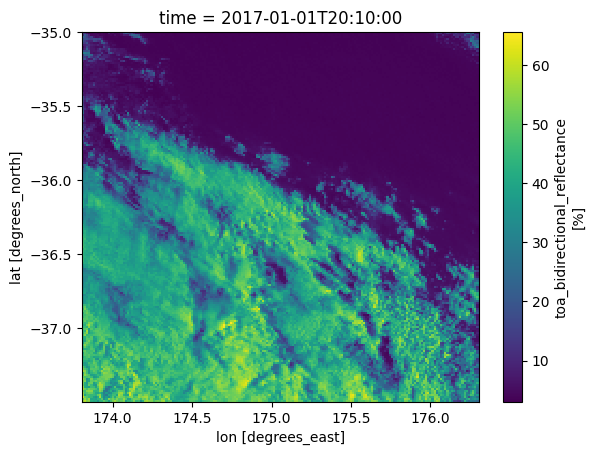

In [15]:
h8_ds.sel(time=valid_timesteps[3])['B03'].plot()

### Load station data using the stations loader
Use csv mode, as the stations data has been provided in a new file format

In [ ]:
%autoreload 2
from convcnp_assim_nz.data_processing.station_processor import ProcessStations

In [17]:
stations_loader = ProcessStations(mode='csv')

In [18]:
stations = stations_loader.load_df([TEMPERATURE], csv_file='esnz-observations_temp_20170101-20171231.csv', year_start=2017, year_end=2017)

Loaded CSV with length 2153680
Loaded CSV with length 2148123


In [19]:
from mpl_toolkits.basemap import Basemap

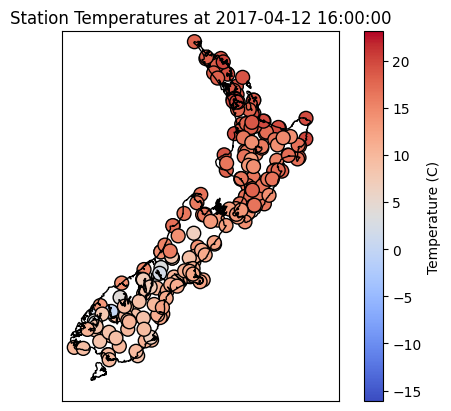

In [20]:
time_step = "2017-04-12 16:00:00"
m = Basemap(projection='merc', llcrnrlat=-48, urcrnrlat=-34, llcrnrlon=166, urcrnrlon=180, resolution='i')
m.drawcoastlines()
m.drawcountries()
x, y = m(stations.reset_index().loc[stations.reset_index()['time'] == time_step]['lon'].values,
           stations.reset_index().loc[stations.reset_index()['time'] == time_step]['lat'].values)
sc = m.scatter(x, y,
               c=stations.reset_index().loc[stations.reset_index()['time'] == time_step]['temperature'].values,
               cmap='coolwarm', marker='o', edgecolor='k', s=100)
plt.colorbar(sc, label='Temperature (C)')
plt.title(f'Station Temperatures at {time_step}')
plt.show()